In [8]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

In [10]:
import config

In [9]:
ORIGINAL_IMAGE_SHAPE = (768, 768)

In [11]:
seg_df = pd.read_csv(config.TRAIN_LABELS_PATH)

In [12]:
def display_image(path, label="Image"):
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.title(label)

def display_random_image_with_label(folder_path, label="Random Image"):
    all_files = os.listdir(folder_path)
    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    if not image_files:
        print("No image files found in the specified folder.")
        return
    random_image_filename = random.choice(image_files)
    random_image_path = os.path.join(folder_path, random_image_filename)
    display_image(random_image_path, label)

In [13]:
def generate_mask_from_encoded_pixels(encoded_pixels, image_shape):
    """
    Generates a binary mask from encoded pixels.

    Parameters:
    - encoded_pixels (str): Encoded pixel information in Run-Length Encoding (RLE) format.
    - image_shape (tuple): Shape of the original image (height, width).

    Returns:
    - numpy array: Binary mask representing the segmentation.
    """
    mask = np.zeros(image_shape, dtype=np.uint8)
    if encoded_pixels == "nan":
      return mask
    pairs = encoded_pixels.split()

    # Decode the RLE pairs
    for i in range(0, len(pairs), 2):
        start = int(pairs[i]) - 1  # Convert to 0-based index
        length = int(pairs[i + 1])
        end = start + length

        start_row, start_col = divmod(start, image_shape[0])
        end_row, end_col = divmod(end, image_shape[0])

        mask[start_row:end_row + 1, start_col:end_col + 1] = 1

    return mask


In [14]:
def get_combined_mask(image_id, seg_df, image_shape):
    image_df = seg_df[seg_df["ImageId"] == image_id]
    masks = []
    combined_mask = None
    for _, row in image_df.iterrows():
        encoded_pixels = str(row["EncodedPixels"])
        mask = generate_mask_from_encoded_pixels(encoded_pixels, image_shape)
        masks.append(mask)
    if masks:
        combined_mask = np.sum(np.array(masks), axis=0)
    return combined_mask

def display_random_image_with_mask(folder_path, seg_df, image_shape):
    random_index = random.randint(0, len(seg_df) - 1)
    image_id = seg_df.iloc[random_index]["ImageId"]

    path = os.path.join(folder_path, image_id)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    try:
        display_image(path, f"Image: {image_id}")
    except FileNotFoundError:
        print("No image found.")

    plt.subplot(1, 2, 2)
    combined_mask = get_combined_mask(image_id, seg_df, image_shape)
    if combined_mask is not None:
        plt.imshow(combined_mask.T, cmap='gray')
        plt.title("Combined Mask")
    else:
        plt.text(0.5, 0.5, "No masks", horizontalalignment='center', verticalalignment='center', fontsize=12)

    plt.show()


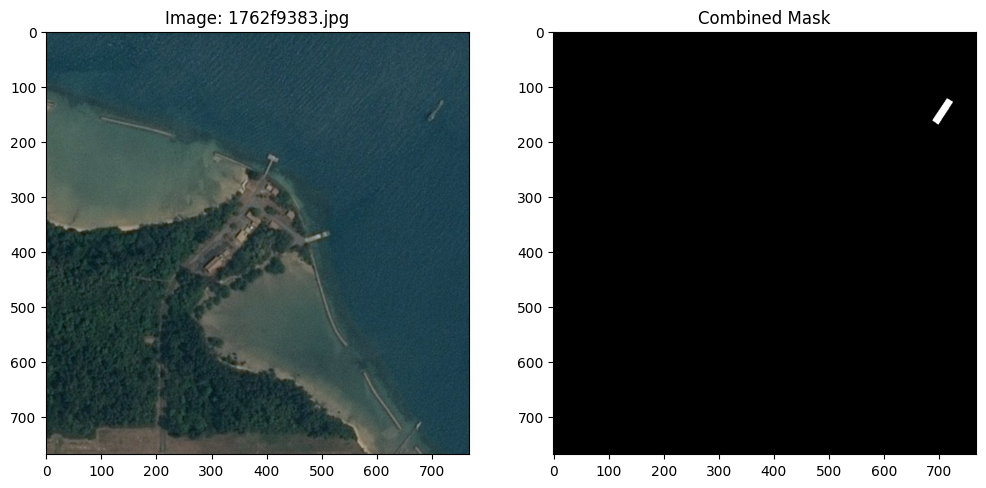

In [15]:
display_random_image_with_mask(config.TRAIN_PATH, seg_df, ORIGINAL_IMAGE_SHAPE)

In [16]:
print(f"{len(seg_df[seg_df['EncodedPixels'].isna()]) / len(seg_df['EncodedPixels']) * 100:.2f}% of rows without boats")


64.73% of rows without boats


In [ ]:
print(f"{len(seg_df['ImageId'].unique()) / len(seg_df['ImageId']) * 100:.2f}% of rows have unique id")

In [18]:
temp = pd.DataFrame(seg_df.groupby("ImageId").size().sort_values(ascending=False).reset_index(name="Count"))
temp.head()

,ImageId,Count
0,e6fd0c12e.jpg,15
1,2053a78bd.jpg,15
2,d3c47b3d3.jpg,15
3,4de149bd9.jpg,15
4,c8e722430.jpg,15


<Axes: ylabel='Count'>

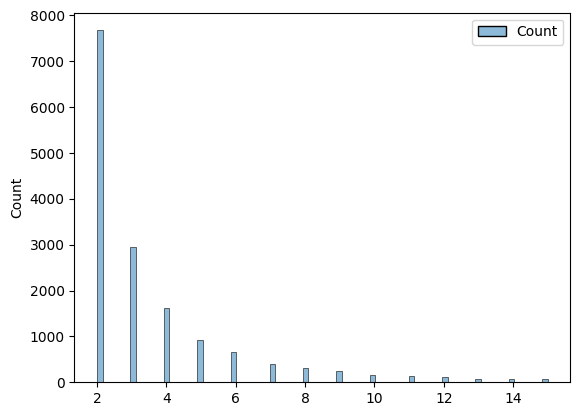

In [20]:
import seaborn as sns
sns.histplot(temp[temp["Count"] > 1])

In [21]:
x = seg_df[seg_df['ImageId'].isin(temp[temp["Count"] > 1]['ImageId'])]
print(f"{len(x[x['EncodedPixels'].isna()]) / len(x['EncodedPixels']) * 100:.2f}% of images without boats. {len(x)/len(seg_df) * 100:.2f}% of data")

0.00% of images without boats. 23.57% of data


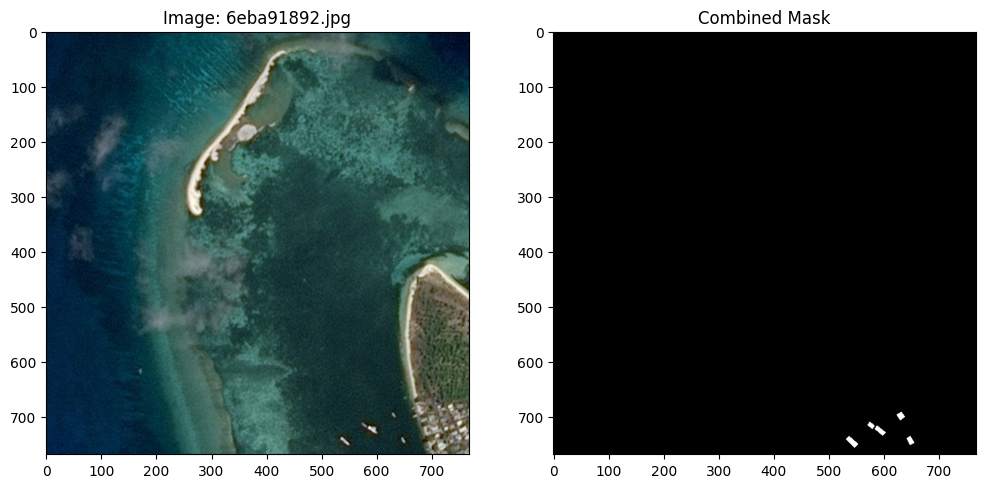

In [24]:
display_random_image_with_mask(config.TRAIN_PATH, x, ORIGINAL_IMAGE_SHAPE)